### benchmark.
building a basic $E(3)$-equivariant message-passing graph neural network to predict (??) on QM9 to make sure I am comfortable with this stuff in practice as well as in theory.

### import everything.
I only use Data and Dataset from PyTorch_Geometric, and these are honestly not very helpful because I'll have to write custom utilities to do MBGD with the Torch_Geometric DataLoader. I think once I get this working I will rewrite using only vanilla PyTorch and make a custom Graph class.

In [1]:
import math
from itertools import product
from typing import List
import random
import pandas as pd
import torch
from torch import Tensor, LongTensor
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Dataset
import matplotlib.pyplot as plt

### model components.  
the EVGNN has everything.  
EVMPLayer is message-passing.  
RowWiseFCL is just a FCL thta operations on a tensor of an arbitrary row-length, since we want to be able to operate atom-wise on a molecule of an arbitrary number of atoms.  

In [2]:
class EVGNN(nn.Module):
    def __init__(self) -> None:
        super(EVGNN, self).__init__()
        # size of the embedding space
        self.embed_dim = 4
        
        self.embedding = nn.Embedding(118, self.embed_dim)
        self.mp1 = EVMPLayer(self.embed_dim)
        self.prediction1 = RowWiseFCL(self.embed_dim, 1) 

    def forward(self, data = Data) -> float:
        print('IN MODEL\n', data)
        x = self.embedding(data['x'])
        print('EMBEDDING\n', x)
        x = self.mp1(x, data.edge_distances)
        x = F.normalize(x, p=1, dim=0)
        print('MESSAGE PASSING 1\n', x)
        x = self.prediction1(x)
        print('PREDICTION 1\n', x)
        U_hat = torch.sum(x)
        print('FINAL PREDICTION\n', U_hat)

        return U_hat

In [3]:
class EVMPLayer(nn.Module):
    def __init__(self, embed_dim: int) -> None:
        super(EVMPLayer, self).__init__()
        self.embed_dim = embed_dim
        self.act = nn.Tanh()
        message_input_size = 2 * embed_dim + 1
        
        # take in a message tensor of size 2 * embed_dim + 1 and get out a new h_i of size embed_dim
        self.message_mlp = nn.Sequential(nn.Linear(message_input_size, embed_dim), self.act)
        
        # take in a message tensor of size embed_dim and an original h_i of size embed_dim and get out a new h_i of size embed_dim
        self.update_node_mlp = nn.Sequential(nn.Linear(2 * embed_dim, embed_dim), self.act)
                
    def make_message(self, source_tensor: int, target_tensor: int, distance: float) -> Tensor:
        combined_tensor = torch.cat((source_tensor.view(-1), target_tensor.view(-1), torch.Tensor([distance])))
        return self.message_mlp(combined_tensor)
    
    def update_node(self, node_tensor: Tensor, message_tensor: Tensor) -> Tensor:
        combined_tensor = torch.cat((node_tensor, message_tensor)).view(1,-1)
        return self.update_node_mlp(combined_tensor)
    
    def forward(self, embed_tensor: Tensor, edge_distances: Tensor) -> Tensor:
        new_embed_tensor = torch.zeros_like(embed_tensor)
        # for each molecule in the dataset
        for ix, source in enumerate(embed_tensor):
            # create a tensor that tracks the sum of the messages
            message_sum = torch.zeros_like(source)
            # for each other molecule in the dataset
            for jx, target in enumerate(embed_tensor):
                if ix != jx:
                    # add the message tensor between them to the sum tensor
                    message_sum += self.make_message(source, target, edge_distances[ix,jx].item())
            # update the tensor that keeps track of all molecule embeddings by making its row ix the new embedding of the molecule
            new_embed_tensor[ix] = self.update_node(source, message_sum)
        
        return new_embed_tensor
            

In [4]:
class RowWiseFCL(nn.Module): 
    def __init__(self, in_dim: int, out_dim: int) -> None: 
        super(RowWiseFCL, self).__init__() 
        self.out_dim = out_dim
        self.row_layer = nn.Sequential(nn.Linear(in_dim, out_dim), nn.Tanh())
      
    def forward(self, embed_tensor: Tensor) -> Tensor:
        new_embed_tensor = torch.zeros(embed_tensor.size(0), self.out_dim)
        for ix, row in enumerate(embed_tensor):
            new_embed_tensor[ix] = self.row_layer(row)
        return new_embed_tensor

### dataset class.  
pretty stupid. just a wrapper for Data objects. the point was to be able to pass this into a DataLoader, but the PyTorch_Geometric DataLoader seems more trouble than it's worth, so as mentioned above, this will probably be deprecated soon.

In [5]:
class MoleculesDataset(Dataset):
    def __init__(self, data: List[Data]) -> None:
        super().__init__()
        self.data = data
        
    def len(self) -> int:
        return len(self.data)
    
    def get(self, idx: int) -> Data:
        return self.data[idx]

### helper functions.
all self-explanitory. makes it simpler to build the Data items.

In [6]:
def compute_distance(pos1: Tensor, pos2: Tensor) -> float:
    return torch.sum(torch.pow(torch.sub(pos1, pos2), 2)).item()

In [7]:
def make_complete_edge_indices(n: int) -> LongTensor:
    edges = list(filter(lambda e: e[0] != e[1], product(range(n), range(n))))
    return torch.tensor(edges, dtype=torch.long).T

In [8]:
def make_edge_distances(positions: Tensor) -> Tensor:
    edge_distances = torch.zeros(positions.size(0), positions.size(0))
    for ix, source_position in enumerate(positions):
        for jx, target_position in enumerate(positions):
            edge_distances[ix][jx] = compute_distance(source_position, target_position)
    return edge_distances

### build the dataset from saved CSVs.  
makes custom Data objects.  
$x$ is atomic numbers.  
$pos$ is positions.
full connectivity.  
$edge\_distances$ is a matrix containing the distance from atom $i$ to atom $j$. it si saved with the Data instance so this can all be calculated up front and not waste computatino each time through message passing.

In [9]:
path_head = 'baby_QM9/raw/'

node_features_df = pd.read_csv(path_head + 'node_attributes.txt', header=None)
node_features = torch.tensor(node_features_df.values)

graph_features_df = pd.read_csv(path_head + 'Y.txt', header=None)
graph_features = torch.tensor(graph_features_df.values)

atomic_numbers = node_features[:,5].long()

positions = node_features[:,-3:]

atomization_energies = graph_features[:,13]
atomization_energies_list = atomization_energies.tolist()

new_graph_node_indices = [0]
node_indicators_df = pd.read_csv(path_head + 'graph_indicator.txt', header=None)
node_indicators = node_indicators_df.values.tolist()
for ix in range(len((node_indicators)))[1:]:
    if node_indicators[ix] != node_indicators[ix-1]:
        new_graph_node_indices.append(ix)
new_graph_node_indices.append(len(node_indicators))

molecules_list = []
for start, end in zip(new_graph_node_indices, new_graph_node_indices[1:]):
    x = atomic_numbers.clone()[start:end].view(-1, 1)
    edge_index = make_complete_edge_indices(end-start)
    y = torch.Tensor([atomization_energies_list.pop(0)])
    pos = positions.clone()[start:end]
    edge_distances = make_edge_distances(pos)
    molecule = Data(x = x, edge_index = edge_index, y = y, pos = pos, edge_distances = edge_distances)
    molecules_list.append(molecule)
    
molecules_dataset = MoleculesDataset(molecules_list)

### build model and run it.

In [10]:
model = EVGNN()
optim = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
losses = []
predictions = []
targets = []
epochs = range(1000)

# training loop
model.train()
data = molecules_dataset[1]
for epoch in epochs:
    # for data in molecules_dataset[:1]:
    U_hat = model(data)
    predictions.append(U_hat.item())
    U = data['y']
    targets.append(U.item())
    loss = loss_fn(U_hat, U)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()

IN MODEL
 Data(x=[4, 1], edge_index=[2, 12], y=[1], pos=[4, 3], edge_distances=[4, 4])
EMBEDDING
 tensor([[[ 0.0843,  1.8110,  0.2990,  0.1591]],

        [[ 1.4779,  0.1947, -0.6903, -1.6795]],

        [[ 1.4779,  0.1947, -0.6903, -1.6795]],

        [[ 1.4779,  0.1947, -0.6903, -1.6795]]], grad_fn=<EmbeddingBackward0>)
MESSAGE PASSING 1
 tensor([[[-0.5781, -0.4926, -0.1554,  0.1139]],

        [[-0.1406, -0.1692,  0.2816,  0.2954]],

        [[-0.1406, -0.1692,  0.2816,  0.2954]],

        [[-0.1406, -0.1691,  0.2815,  0.2954]]], grad_fn=<DivBackward0>)
PREDICTION 1
 tensor([[-0.5246],
        [-0.3616],
        [-0.3616],
        [-0.3616]], grad_fn=<CopySlices>)
FINAL PREDICTION
 tensor(-1.6095, grad_fn=<SumBackward0>)
IN MODEL
 Data(x=[4, 1], edge_index=[2, 12], y=[1], pos=[4, 3], edge_distances=[4, 4])
EMBEDDING
 tensor([[[ 0.0743,  1.8210,  0.3090,  0.1691]],

        [[ 1.4679,  0.2047, -0.6803, -1.6895]],

        [[ 1.4679,  0.2047, -0.6803, -1.6895]],

        [[ 1.4679,  0

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MESSAGE PASSING 1
 tensor([[[-0.8828, -0.2599, -0.2757,  0.0223]],

        [[-0.0390, -0.2467, -0.2414,  0.3259]],

        [[-0.0390, -0.2467, -0.2414,  0.3259]],

        [[-0.0391, -0.2467, -0.2414,  0.3259]]], grad_fn=<DivBackward0>)
PREDICTION 1
 tensor([[-0.6649],
        [-0.6578],
        [-0.6578],
        [-0.6578]], grad_fn=<CopySlices>)
FINAL PREDICTION
 tensor(-2.6382, grad_fn=<SumBackward0>)
IN MODEL
 Data(x=[4, 1], edge_index=[2, 12], y=[1], pos=[4, 3], edge_distances=[4, 4])
EMBEDDING
 tensor([[[ 0.0079,  1.8788,  0.3544,  0.1735]],

        [[ 1.4051,  0.2746, -0.6106, -1.7584]],

        [[ 1.4051,  0.2746, -0.6106, -1.7584]],

        [[ 1.4051,  0.2746, -0.6106, -1.7584]]], grad_fn=<EmbeddingBackward0>)
MESSAGE PASSING 1
 tensor([[[-0.9353, -0.2590, -0.2731,  0.0474]],

        [[-0.0216, -0.2470, -0.2423,  0.3175]],

        [[-0.0215, -0.2470, -0.2423,  0.3175]],

        [[-0.0216, -0.2470, -0.2423,  0.3175]]], grad_fn=<DivBackward0>)
PREDICTION 1
 tensor([[-0.6

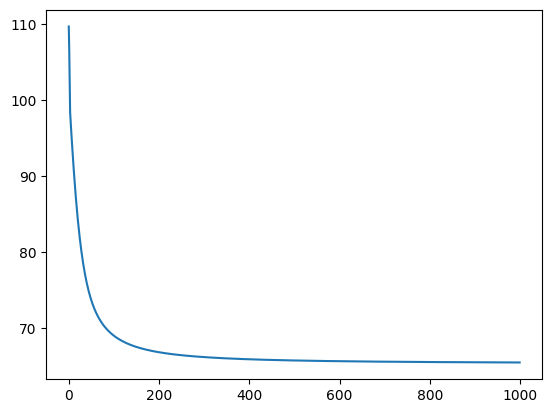

In [11]:
import matplotlib.pyplot as plt

xs = [x for x in range(len(losses))]

# plt.plot(xs, losses)
plt.plot(xs, losses)
plt.show()
plt.close()

In [12]:
for prediction in predictions:
    print(prediction)

-1.6094590425491333
-1.7488027811050415
-1.9486507177352905
-2.1628565788269043
-2.2173991203308105
-2.2677321434020996
-2.3172128200531006
-2.366000175476074
-2.413978099822998
-2.4610233306884766
-2.5070385932922363
-2.551950216293335
-2.594320774078369
-2.63822340965271
-2.67941951751709
-2.7194080352783203
-2.758297920227051
-2.7960174083709717
-2.8324971199035645
-2.8677337169647217
-2.901749849319458
-2.9345736503601074
-2.966233015060425
-2.996756076812744
-3.026172161102295
-3.0545098781585693
-3.0817997455596924
-3.108072519302368
-3.133359432220459
-3.1576926708221436
-3.181103467941284
-3.2036244869232178
-3.225287437438965
-3.246123790740967
-3.2661643028259277
-3.28544020652771
-3.303981304168701
-3.3218166828155518
-3.338975429534912
-3.355485439300537
-3.371372938156128
-3.386665105819702
-3.4013864994049072
-3.4155616760253906
-3.4292142391204834
-3.442366600036621
-3.455040693283081
-3.467257261276245
-3.479036569595337
-3.4903972148895264
-3.5013575553894043
-3.511935